
# Convolutional Neural Network CNN
1. Using Word2Vec implementing CNN model
2. Dispaly Confusion Matrix, precision, recall and F1-score
3. Display few prediction using predict module. 
4. Get 10-fold Average of the CNN model.

In [192]:
from __future__ import division, print_function

# dataframe
import pandas as pd

# numpy array
import numpy as np

# figures visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# word2vec
import gensim 
from gensim import models
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

# CNN model and keras preprocessing
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# nltk data preprocessing
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

# stopword - remove buzz word
from nltk.corpus import stopwords

# splitting data
from sklearn.model_selection import train_test_split

# punctuation - data imbalance
import collections
import re
import string

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

In [193]:
# original hindi file
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [194]:
orig_df.head

<bound method NDFrame.head of                                                    Text  Label
0     'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #Is...      2
1        '@SanjayGadhiaINC @IndiaToday18 अज़ाबे इलाही 👍      1
2     'आखिर अब #सुशांत_सिंह_राजपूत जी को न्याय मिल ज...      0
3     'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के ग...      0
4     '@deoriapolice @Uppolice @myogiadityanath @spg...      0
...                                                 ...    ...
8788                  '@atullondhe राहुल गांधी जिंदाबाद      0
8789  'पैगंबर हज़रत मुहम्मद सल्लल्लाहु अलैहि वसल्लम ...      1
8790  'कर्नाटक बेंगलुरू में अल्लाह मोहम्मद गांडू के ...      2
8791  'अच्छी खबर है ऐसे एक एक कर सभी जेहादी भारतीय फ...      2
8792  '@Ruzena__Malik जनता चाइना से दीवाली की लड़ी ख...      0

[8793 rows x 2 columns]>

In [196]:
orig_df.Text[6]

In [197]:
data["Text"] = orig_df["Text"].astype(str)
data["Label"] = orig_df["Label"].astype(str)

### Class count

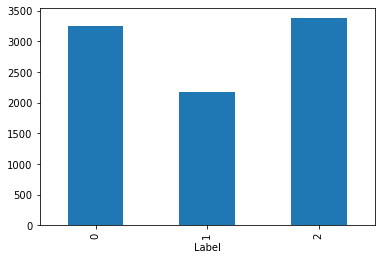

In [198]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [199]:
# For entire dataset sentences for each labels 
data.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

### Balancing Data

In [200]:
data=data.sample(frac=1).reset_index(drop=True)
data

,Text,Label
0,'भारत को 2011 का क्रिकेट विश्वकप दिलाने में सब...,0
1,'@narendramodi @AmitShah इस जेहादी संगठन को ...,2
2,'ठीक है टाइम निकालो फिर हम भी कौन सा सुशांत ...,0
3,'@ThePushpendra_ एक जेहादी कम हुआ,2
4,'@ModiNama01 शानदार जबरदस्त जिंदाबाद 👌👌,0
...,...,...
8788,"'आलम-ए-इस्लाम को इस्लामिक नया साल ""1442 हिज़री...",1
8789,'@BadmaashJimmy @sambitswaraj जेहादी चुप बैठ,2
8790,@mewati0786 @RahulSh48297908 @anuraagmuskaan न...,2
8791,@Ravishk256 @RahulGandhi ये है ravish kumar जै...,2


### Data Preprocessing

In [201]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"\*", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [202]:
data.shape

(8793, 2)

In [203]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [204]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [205]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [206]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [207]:
# Removing Stopwords
stoplist=open("Devanagari/stopwords.txt","r")

In [208]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [209]:
zero  = []
one = []
two = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
        two.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        two.append(0)
    elif l == '2':
        zero.append(0)
        one.append(0)
        two.append(1)
        
data['0']= zero
data['1']= one
data['2']= two

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2']]

In [210]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
    elif l == '2':
        category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2', 'Category_id' ]]
data.head(25)

,Text_Final,tokens,Label,0,1,2,Category_id
0,भारत को 2011 का क्रिकेट विश्वकप दिलाने में सबस...,"[भारत, को, 2011, का, क्रिकेट, विश्वकप, दिलाने,...",0,1,0,0,0
1,narendramodi amitshah इस जेहादी संगठन को जल्द ...,"[narendramodi, amitshah, इस, जेहादी, संगठन, को...",2,0,0,1,2
2,ठीक है टाइम निकालो फिर हम भी कौन सा सुशांत सिं...,"[ठीक, है, टाइम, निकालो, फिर, हम, भी, कौन, सा, ...",0,1,0,0,0
3,thepushpendra_ एक जेहादी कम हुआ,"[thepushpendra_, एक, जेहादी, कम, हुआ]",2,0,0,1,2
4,modinama01 शानदार जबरदस्त जिंदाबाद 👌👌,"[modinama01, शानदार, जबरदस्त, जिंदाबाद, 👌👌]",0,1,0,0,0
5,thedeepak2020in जेहादी की आत्मा को भगवान शांति...,"[thedeepak2020in, जेहादी, की, आत्मा, को, भगवान...",2,0,0,1,2
6,haseena79360293 wafachaudhry251 isrartyagi8 sy...,"[haseena79360293, wafachaudhry251, isrartyagi8...",1,0,1,0,1
7,salmannizami_ यह दुनिया की no 1 terrorist फैक्...,"[salmannizami_, यह, दुनिया, की, no, 1, terrori...",2,0,0,1,2
8,ये जैहादी टीना डावी ( ia ) जिसे लव मैरिज किया ...,"[ये, जैहादी, टीना, डावी, (, ia, ), जिसे, लव, म...",2,0,0,1,2
9,_sabanaqvi इन जिहादियों का भी है कोई बाप या फि...,"[_sabanaqvi, इन, जिहादियों, का, भी, है, कोई, ब...",2,0,0,1,2


In [211]:
data = data[data.tokens != '']

In [212]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

In [213]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)


In [214]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google News Glove model

In [131]:
# Run only once
# Convert Glove file to word2vec format 
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.300d.txt'  # I unzipped in glove.6B subdirectory 
word2vec_output_file = 'glove.6B.300d.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 300)

In [132]:
# Use the converted Glove file
filename = 'glove.6B.300d.word2vec'
word2vec = KeyedVectors.load_word2vec_format(filename, binary=False)

In [215]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 300


### Tokenize and Pad sequences

In [216]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 19047 unique tokens.


In [217]:
cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [218]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(19048, 300)


In [219]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

The model is from the paper 'Convolutional Neural Networks for Sentence Classification' we have updated the network according to our requirement [1]

In [220]:
label_names = ['0', '1', '2']

In [221]:
def ConvolutionalNeuralNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    # Embedding layer
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    
    #Kernal (window) size
    filter_sizes = [2,3,4,5]

    # Convolution Layer and max-pooling
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)
    
    # softmax layer for multiclass identification 
    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss= 'categorical_crossentropy',
                 optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
#                    optimizer='adam',
                  metrics=['accuracy'])
    return model

In [222]:
# Splitting train data into X_train and y_train
y_train = data_train[label_names].values
x_train = cnnTrainData
y_tr = y_train

In [223]:
# Splitting train data into X_test and y_test
y_test = data_test[label_names].values
x_test = cnnTestData
y_tst = y_test

In [224]:
model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

In [225]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 150, 300)     5714400     input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 149, 512)     307712      embedding_12[0][0]               
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 148, 512)     461312      embedding_12[0][0]               
___________________________________________________________________________________________

### Train CNN

In [226]:
num_epochs = 10
batch_size = 512

In [227]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/10
14/14 [==============================] - 40s 3s/step - loss: 6.1324 - accuracy: 0.3884 - val_loss: 1.0337 - val_accuracy: 0.5000
Epoch 2/10
14/14 [==============================] - 40s 3s/step - loss: 1.0226 - accuracy: 0.4730 - val_loss: 0.8967 - val_accuracy: 0.5720
Epoch 3/10
14/14 [==============================] - 40s 3s/step - loss: 0.8963 - accuracy: 0.5644 - val_loss: 0.8519 - val_accuracy: 0.5366
Epoch 4/10
14/14 [==============================] - 40s 3s/step - loss: 0.8836 - accuracy: 0.6225 - val_loss: 0.6149 - val_accuracy: 0.8005
Epoch 5/10
14/14 [==============================] - 40s 3s/step - loss: 0.5757 - accuracy: 0.7823 - val_loss: 0.5522 - val_accuracy: 0.7652
Epoch 6/10
14/14 [==============================] - 39s 3s/step - loss: 0.4023 - accuracy: 0.8479 - val_loss: 0.5276 - val_accuracy: 0.7828
Epoch 7/10
14/14 [==============================] - 40s 3s/step - loss: 0.4257 - accuracy: 0.8440 - val_loss: 0.4816 - val_accuracy: 0.8144
Epoch 8/10
14/14 [==

In [228]:
# evaluate on test data
results = model.evaluate(x_test, y_tst)

28/28 [==============================] - 2s 79ms/step - loss: 0.3057 - accuracy: 0.8966


In [229]:
# predict model
predictions = model.predict(cnnTestData, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 2ms/step


### Testing few sentences using our model

In [230]:

labels = ['0', '1', '2']

def makeprediction(texts):
    tk = Tokenizer()
    tk.fit_on_texts(texts)
    index_list = tk.texts_to_sequences(texts)
    x_train = pad_sequences(index_list, maxlen=150)
    pred = model.predict(x_train)
    result = labels[np.argmax(pred)]
    return result

In [231]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [232]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.8965909090909091

In [233]:
data_test.Label.value_counts()

2    341
0    320
1    219
Name: Label, dtype: int64

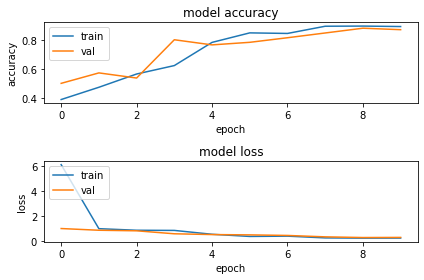

In [234]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [235]:
results = confusion_matrix(data_test.Label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.Label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.Label, prediction_labels))

Confusion Matrix :
[[275  23  22]
 [ 11 191  17]
 [  4  14 323]]
Accuracy Score : 0.8965909090909091
Report : 
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       320
           1       0.84      0.87      0.85       219
           2       0.89      0.95      0.92       341

    accuracy                           0.90       880
   macro avg       0.89      0.89      0.89       880
weighted avg       0.90      0.90      0.90       880



                        Convolution Neural Network


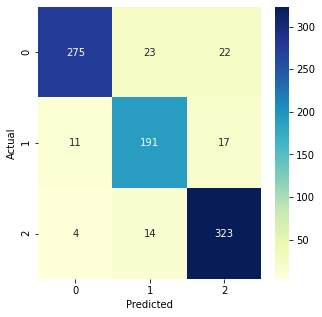

In [236]:
from sklearn.metrics import confusion_matrix
print("                        Convolution Neural Network")
conf_mat = confusion_matrix(data_test.Label, prediction_labels)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Testing CNN using KFold cross validation

In [237]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import zscore
from sklearn import metrics
import tensorflow as tf
import random

f_score=[]
fold = 10
label_names = ['0', '1', '2']
num_epochs = 5
batch_size = 32
#oos_y = []
#oos_pred = []
results = []
#for train, test in kf.split(data["tokens"], data['Label']):

for i in range(fold):
    print("Fold: ", i+1)
    random_num = np.random.randint(1,7000, 1)[0]
    data_train, data_test = train_test_split(data, test_size=0.10, shuffle = True, random_state = random_num)

    # # total training words
    totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

    # # Storing Length of the training sentence
    lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

    # # training Vocabulary size
    trainingVocabSize = sorted(list(set(totalTrainingWords)))

    ## Total number of lines
    linesCount = len(data_train["tokens"])
    
    tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
    tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
    training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

    train_word_index = tokenizer.word_index
    cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
    
    for word,index in train_word_index.items():
        train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
        
    test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
    cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)
    
    # Splitting train data into X_train and y_train
    y_train = data_train[label_names].values
    x_train = cnnTrainData
    y_tr = y_train
    
    # Splitting train data into X_test and y_test
    y_test = data_test[label_names].values
    x_test = cnnTestData
    y_tst = y_test
    
    # create model
    model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))
    
    #Train Model
    history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
      
    # model evaluate
    
    print("Results for current fold:")
    results.append(model.evaluate(x_test, y_tst, batch_size=128))

model.save('model_CNN.h5')    

Fold:  1
Epoch 1/5
223/223 [==============================] - 53s 239ms/step - loss: 0.9047 - accuracy: 0.7106 - val_loss: 0.4819 - val_accuracy: 0.8106
Epoch 2/5
223/223 [==============================] - 52s 232ms/step - loss: 0.3006 - accuracy: 0.8871 - val_loss: 0.3281 - val_accuracy: 0.8914
Epoch 3/5
223/223 [==============================] - 53s 238ms/step - loss: 0.2379 - accuracy: 0.9167 - val_loss: 0.2789 - val_accuracy: 0.9053
Epoch 4/5
223/223 [==============================] - 54s 240ms/step - loss: 0.2019 - accuracy: 0.9334 - val_loss: 0.4728 - val_accuracy: 0.9141
Epoch 5/5
223/223 [==============================] - 54s 242ms/step - loss: 0.1844 - accuracy: 0.9360 - val_loss: 0.3457 - val_accuracy: 0.9192
Results for current fold:
7/7 [==============================] - 2s 235ms/step - loss: 0.2205 - accuracy: 0.9341
Fold:  2
Epoch 1/5
223/223 [==============================] - 54s 242ms/step - loss: 0.9714 - accuracy: 0.6901 - val_loss: 0.3485 - val_accuracy: 0.8434
Epoch

In [238]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.8988636493682861


In [239]:
# Prediction 
# translator
translator = Translator()

In [240]:
# 0
texts = ["Sachin: Once there was a fight between Yusuf and Bhajji. Sehwag: Paji, was he Muhammad Yusuf or Yusuf Youhana at that time. This man will not let him live even after retirement."]
print(makeprediction(texts))

0


In [241]:
# 2
texts = ["@_ROB_29 If this was a Muslim girl in Afghanistan you'd call her a terrorist"]
print(makeprediction(texts))

2


In [242]:
# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
texts = [hin_text]
print('Predicted Label: ',makeprediction(texts))

Predicted Label:  2


In [243]:
# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "

texts = [hin_text]
print('Predicted Label: ',makeprediction(texts))

Predicted Label:  0


In [244]:
# 1
hin_text =  "इसलाम सुंदर है"
texts = [hin_text]
print('Predicted Label: ',makeprediction(texts))

Predicted Label:  0


### Reference
[1] "Convolutional Neural Networks for Sentence Classification" by Yoon Kim
